In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
idx = pd.IndexSlice
warnings.simplefilter(action='ignore', category=FutureWarning)   
from random import seed
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import mean_squared_error
import math
from sklearn.ensemble import GradientBoostingRegressor
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import stattools
import hashlib # for grading purposes
from sklearn.model_selection import ParameterGrid

from pandas.plotting import lag_plot
from statsmodels.tsa.arima_model import ARIMA
plt.rcParams['figure.figsize'] = (12, 4)

from utils import *

%matplotlib inline

In [2]:
data = pd.read_csv('data/data.csv')
data.value = data.value.map(np.log)
data.sample(6)

,date,variable,value
2290,2004-04-05 10:00:00,area_1,2.914468
8410,2004-12-16 10:00:00,area_1,3.139010
9241,2005-01-20 01:00:00,area_1,2.949584
47247,2005-06-22 15:00:00,area_3,NaN
36204,2004-03-19 12:00:00,area_3,4.387275
7336,2004-11-01 16:00:00,area_1,2.732222


In [3]:
data['date']=pd.to_datetime(data['date'])

In [4]:
data = data.set_index(['date','variable'])


In [5]:
data = data.sort_index()

In [6]:
area1 = data.loc[idx[:,'area_1'],:].reset_index(level='variable',drop=True)
area1 = area1.loc[:area1[area1.value.isnull() == False].iloc[-1].name]
area1.value = area1.value.interpolate()

area2 = data.loc[idx[:,'area_2'],:].reset_index(level='variable',drop=True)
area2 = area2.loc[:area2[area2.value.isnull() == False].iloc[-1].name]
area2.value = area2.value.interpolate()

area3 = data.loc[idx[:,'area_3'],:].reset_index(level='variable',drop=True)
area3 = area3.loc[:area3[area3.value.isnull() == False].iloc[-1].name]
area3.value = area3.value.interpolate()

# area1.head(5)

In [36]:
area1_logged = area2['value'].map(np.log)
area1_logged_diffed = area1_logged.diff()

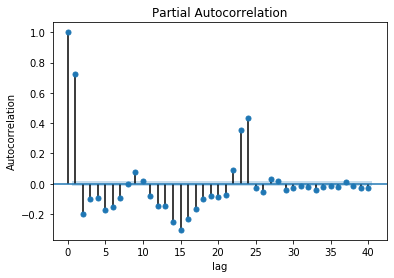

In [37]:
plot_pacf(area1_logged_diffed.dropna(), alpha=.05, lags=40)  
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

In [38]:
#data.loc[idx[:,'area_2'],:].unstack(1).value.plot()

In [39]:
#data.loc[idx[:,'area_1'],:].unstack(1).value.plot()

In [46]:
p = q = [1]
d = [0]
P = D = Q = range(0, 2)   #  <--- all of the paramters between 0 and 2 

S = [24] # <-- let's pretend we have a couple of hypothesis 

In [47]:
params_combinations = list(itertools.product(p, d, q, P, D, Q, S))

In [48]:
inputs = [[x[0], x[1], x[2], x[3], x[4], x[5], x[6]] for x in params_combinations]

In [49]:
def get_aic(series_, params):
    # extract the params 
    p = params[0] 
    d = params[1] 
    q = params[2] 
    P = params[3]
    D = params[4] 
    Q = params[5]
    S = params[6]
    
    # fit a model with those params 
    model = SARIMAX(series_,order=(p, d, q), seasonal_order=(P, D, Q, S),
                                     enforce_stationarity=False,
                                     enforce_invertibility=False)
    
    # fit the model
    results = model.fit(maxiter=200)
    predictions_best_model = results.get_prediction()
    mep = mean_absolute_percentage_error(series_[1:],np.exp(predictions_best_model.predicted_mean)[1:])
    
    # return the aic 
    return mep

In [50]:
%%time 

aic_scores = {}
params_index = {}

for i in range(len(inputs)):
    try: 
        param_set = inputs[i]
        aic = get_aic(area1_logged, param_set) 
        aic_scores[i] = aic
        params_index[i] = param_set
    
    # this will fail sometimes with impossible parameter combinations. 
    # ... and I'm too lazy to remember what they are. 
    except Exception as e: 
        continue

/home/fc/anaconda3/envs/hckt03/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/home/fc/anaconda3/envs/hckt03/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/home/fc/anaconda3/envs/hckt03/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/home/fc/anaconda3/envs/hckt03/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/fc/anaconda3/envs/hckt03/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information w

CPU times: user 7min 37s, sys: 25.1 s, total: 8min 2s
Wall time: 7min 35s


In [51]:
temp = pd.DataFrame(params_index).T
temp.columns = ['p', 'd', 'q', 'P', 'D', 'Q', 'S']
temp['aic'] = pd.Series(aic_scores)
temp.sort_values('aic').head()

,p,d,q,P,D,Q,S,aic
2,1,0,1,0,1,0,24,213.098596
6,1,0,1,1,1,0,24,213.204708
1,1,0,1,0,0,1,24,213.261106
0,1,0,1,0,0,0,24,213.263024
3,1,0,1,0,1,1,24,213.285867


In [23]:
best_model = SARIMAX(area1_logged,
                                      order=(1, 0, 1),
                                      seasonal_order=(0, 1, 0, 24))

results = best_model.fit()
predictions_best_model = results.get_prediction()

/home/fc/anaconda3/envs/hckt03/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/home/fc/anaconda3/envs/hckt03/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


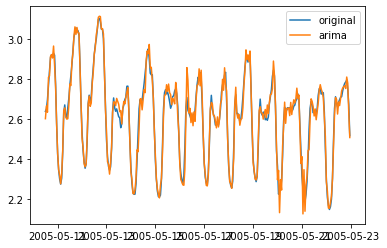

In [25]:
plt.plot(area1[-300:], label='original')
plt.plot(np.exp(predictions_best_model.predicted_mean[-300:]), label='arima')
plt.legend()
plt.show();

In [27]:
train_1 = area1_logged[:-168]
test_1 = area1_logged[-168:]

In [29]:
mae_model = sm.tsa.statespace.SARIMAX(train_1,
                                      order=(1, 0, 1),
                                      seasonal_order=(0, 1, 0, 24))

results = mae_model.fit()
predictions_mae_model = results.get_forecast(steps=168)

/home/fc/anaconda3/envs/hckt03/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


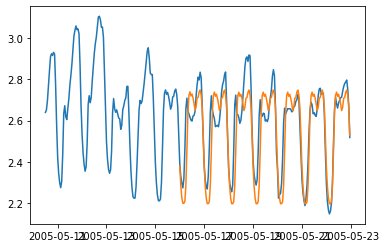

In [33]:
plt.plot(area1[-300:],label='original')
plt.plot(np.exp(predictions_mae_model.predicted_mean), label='arima')
plt.show();

In [34]:
mean_absolute_percentage_error(area1[-24:],np.exp(predictions_mae_model.predicted_mean))

9.555570739624415

In [35]:
area1_pred = np.exp(predictions_mae_model.predicted_mean)

2005-05-16 00:00:00    2.380426
2005-05-16 01:00:00    2.285245
2005-05-16 02:00:00    2.227001
2005-05-16 03:00:00    2.200699
2005-05-16 04:00:00    2.200452
2005-05-16 05:00:00    2.210116
2005-05-16 06:00:00    2.290015
2005-05-16 07:00:00    2.456378
2005-05-16 08:00:00    2.642457
2005-05-16 09:00:00    2.723331
2005-05-16 10:00:00    2.739307
2005-05-16 11:00:00    2.719023
2005-05-16 12:00:00    2.728608
2005-05-16 13:00:00    2.709606
2005-05-16 14:00:00    2.681852
2005-05-16 15:00:00    2.649443
2005-05-16 16:00:00    2.665820
2005-05-16 17:00:00    2.709068
2005-05-16 18:00:00    2.712627
2005-05-16 19:00:00    2.738378
2005-05-16 20:00:00    2.748375
2005-05-16 21:00:00    2.723865
2005-05-16 22:00:00    2.662552
2005-05-16 23:00:00    2.529418
2005-05-17 00:00:00    2.377812
2005-05-17 01:00:00    2.282924
2005-05-17 02:00:00    2.224910
2005-05-17 03:00:00    2.198789
2005-05-17 04:00:00    2.198686
2005-05-17 05:00:00    2.208476
                         ...   
2005-05-